<a href="https://colab.research.google.com/github/arthursl12/POC1/blob/main/POC2_FD001_LSTM_optim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
%pip install scikeras;
%pip install -U tensorflow-addons;
%pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import datetime

H:\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
H:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
H:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import GroupKFold

from sklearn.base import BaseEstimator,RegressorMixin

In [4]:
from skopt import BayesSearchCV

from skopt.space.space import Categorical, Integer, Real

In [5]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Masking

from tensorflow.keras.metrics import RootMeanSquaredError as RMSE

from keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import tensorflow_addons as tfa
from tensorflow_addons.metrics import RSquare as R2

from scikeras.wrappers import KerasRegressor

In [6]:
sns.set_palette('colorblind')

In [7]:
# Reproducibility
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [8]:
tf.config.experimental.enable_op_determinism()

In [9]:
# Remove some tf warnings
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# Data Preparation

In [10]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    IN_COLAB = True
    folder="/content/"

    # Dataset Download 
    os.system('git clone https://github.com/arthursl12/dataset_2')
    os.system('mv /content/dataset_2/CMaps /content/CMaps')
    os.system('mv /content/dataset_2/data_processing /content/data_processing')
    os.system('rm -rf dataset_2')
else:
    print('Not running on CoLab')
    IN_COLAB = False
    folder="CMaps/"
    %cd dataset_2/

Not running on CoLab
C:\Users\Arthur Lima\POC\dataset_2


In [11]:
from data_processing.processing import DatasetProcessing
from data_processing.training import HyperparameterSearch, reclipper_scorer
from data_processing.eval import Evaluation

In [12]:
proc = DatasetProcessing()

## Data Integration

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:  

1) unit number   
2) time, in cycles  
3) operational setting 1  
4) operational setting 2  
5) operational setting 3    
6) sensor measurement 1    
7) sensor measurement 2  
...  
26) sensor measurement 20


There are 6 conditions (or combinations) which the 3 operational settings can take.  
Condition 1: Altitude = 0, Mach Number = 0, TRA = 100  
Condition 2: Altitude = 10, Mach Number = 0.25, TRA = 100  
Condition 3: Altitude = 20, Mach Number = 0.7 TRA = 100  
Condition 4: Altitude = 25, Mach Number = 0.62, TRA = 60  
Condition 5: Altitude = 35 Mach Number = 0.84, TRA = 100  
Condition 6: Altitude = 42, Mach Number = 0.84, TRA = 100  
  
There is slight variation in all these conditions so you may get numbers like 24.453 instead of 25 exactly.

FD001: Condition 1 only  
FD002: Mix of all the conditions  
FD003: Condition 1 only  
FD004: Mix of all conditions  


In [13]:
index_cols, settings_cols, sensors_cols, cols = proc.column_names()
train, test, y_test = proc.read_dataset(1, folder='CMaps/')
train

,unit_number,time,op_1,op_2,op_3,s_0,s_1,s_2,s_3,s_4,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


## Preprocessing

### Validation Set

In [14]:
from sklearn.model_selection import GroupShuffleSplit

def train_val_split(train):
    gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  
    for idx_train, idx_val in gss.split(train,groups=train["unit_number"]):
        # print('train_split_engines', train.iloc[idx_train]['unit_number'].unique(), '\n')
        # print('validate_split_engines', train.iloc[idx_val]['unit_number'].unique(), '\n')

        df_train = train.iloc[idx_train].copy()
        df_val = train.iloc[idx_val].copy()

    return df_train, df_val

In [15]:
df_train, df_val = train_val_split(train)

In [16]:
X_t_train, y_t_train = proc.X_y_train_divide(df_train)
X_t_val, y_t_val = proc.X_y_train_divide(df_val)

### Test Set Transformation 
Test set has samples for all cycles, but has annotations only for last one

In [17]:
test.shape, y_test.shape

((13096, 26), (100, 1))

In [18]:
test_last = proc.transform_test(test)
test_last.head()

,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,518.67,642.58,1581.22,1398.91,14.62,21.61,554.42,2388.08,9056.40,1.3,...,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552
1,518.67,642.55,1586.59,1410.83,14.62,21.61,553.52,2388.10,9044.77,1.3,...,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618
2,518.67,642.88,1589.75,1418.89,14.62,21.61,552.59,2388.16,9049.26,1.3,...,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740
3,518.67,642.78,1594.53,1406.88,14.62,21.61,552.64,2388.13,9051.30,1.3,...,521.88,2388.11,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581
4,518.67,642.27,1589.94,1419.36,14.62,21.61,553.29,2388.10,9053.99,1.3,...,521.00,2388.15,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117


In [19]:
X_test = test_last

### Remaining Useful Life (RUL)

In [20]:
train = proc.add_remaining_useful_life_linear(train)
train[index_cols+['RUL']].head()

,unit_number,time,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


## Attributes and target separation

In [21]:
X_train, y_train = proc.X_y_train_divide(train)

In [22]:
y_train.head()

,RUL
0,191
1,190
2,189
3,188
4,187


In [23]:
X_train.head()

,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## Training and Evaluation functions

In [24]:
eval = Evaluation()

In [25]:
search = HyperparameterSearch()

# LSTM Construction

## Callbacks

In [26]:
# Early Stopping Callback
es = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                      patience=5, restore_best_weights=True)

In [27]:
# Printing Callback
def printLog(epoch, logs):
    print(
        f"E {epoch+1}\t: loss={logs['loss']:.3f}, "+
        f"rmse={logs['root_mean_squared_error']:.3f}, "+
        f"r2={logs['r_square']:.3f}; "+
        f"v_loss={logs['val_loss']:.3f}, "+
        f"v_rmse={logs['val_root_mean_squared_error']:.3f}, "+
        f"v_r2={logs['val_r_square']:.3f}; "
    )

printerCallback = LambdaCallback(on_epoch_end=printLog)

## Auxiliary HyperParameters

In [28]:
layer_sizes=[16,32,64,128,256,512]

In [29]:
# Exponential Decay Schedules
ED1 = ExponentialDecay(initial_learning_rate=1e-2, name="ED1",
                       decay_steps=100000, decay_rate=0.96)
ED2 = ExponentialDecay(initial_learning_rate=1e-2, name="ED2",
                       decay_steps=100000, decay_rate=0.8)
ED3 = ExponentialDecay(initial_learning_rate=1e-1, name="ED3",
                       decay_steps=100000, decay_rate=0.96)

In [30]:
# Generation of list combinations
from itertools import chain, permutations

def all_permutations(lst, size):
    result = list(chain.from_iterable([permutations(lst, x) for x in range(len(lst)+1)]))
    out = []
    for r in result:
        if (len(r) == size):
            out.append(list(r))
    return out

## Constants

In [31]:
seq_cols = [index_cols[1]]+sensors_cols
SEQ_COLS = seq_cols

In [32]:
BASE_SEQ_COLS = [index_cols[1]]+sensors_cols

In [33]:
# X_train must include indices
train3 = train.copy()
X_train_ = train3.drop(columns=["RUL"])

In [ ]:
INPUT_SHAPE = 0

## Wrapper

In [ ]:
from sklearn.metrics import r2_score

class LSTMWrapperRegressor(BaseEstimator,RegressorMixin):
    def __init__(self, basemodel=None, clip_y=-1, seq_length=40,
                 include_settings=False, poly_degree=1,
                 scaler=StandardScaler()):
        # Base parameters
        self.basemodel = basemodel
        self.clip_y = clip_y
        self.seq_length = seq_length
        self.poly_degree = poly_degree
        self.include_settings = include_settings

        # Column indexers
        self.feature_cols = sensors_cols
        if(include_settings):
            # self.seq_cols = settings_cols + self.cols
            self.feature_cols = settings_cols + self.feature_cols
        self.seq_cols = ["time"] + self.feature_cols
        self.base_feature_cols = self.feature_cols

        # Scaler and PolyFeatures transformers
        self.scaler = scaler
        self.polyft = PolynomialFeatures(degree=self.poly_degree, 
                                         include_bias=False)



    def fit(self, X=None, y=None):
        # Merge features and target again
        data = X.copy()
        data["RUL"] = y

        # Apply polynomial features and add them to the dataframe
        transf = self.polyft.fit_transform(data[self.base_feature_cols])
        transf = pd.DataFrame(transf, columns=
                              self.polyft.get_feature_names_out(),
                              index=data.index)
        self.feature_cols = list(self.polyft.get_feature_names_out())
        self.seq_cols = ["time"] + self.feature_cols
        data[self.feature_cols] = transf

        # Scale the data
        data[self.feature_cols] = \
                            self.scaler.fit_transform(data[self.feature_cols])

        # Transform into time series
        X_train = self.gen_X_wrapper(data,self.seq_length,self.seq_cols)
        # print(data.shape,X_train.shape, X.shape)

        # Clip and transform labels
        data2 = data.copy()
        if (self.clip_y > 0):
            data2["RUL"].clip(upper=self.clip_y, inplace=True)
        y_train = self.gen_y_wrapper(data2,self.seq_length,["RUL"])

        # Update input shape for future use
        global INPUT_SHAPE
        # print(INPUT_SHAPE, X_train.shape)
        INPUT_SHAPE = (X_train.shape[1],X_train.shape[2])

        # Fit model
        # print(X_train.shape, y_train.shape)
        self.basemodel.fit(X_train,y_train)
        return self
        
    def predict(self, X=None):
        # Perform transformation, if not done
        if (len(X.shape) < 3):
            data = X.copy()

            # Apply polynomial features
            transf = self.polyft.transform(data[self.base_feature_cols])
            transf = pd.DataFrame(transf, 
                                  columns=self.polyft.get_feature_names_out(),
                                  index=data.index)
            # data = pd.concat([data,transf], axis=1)
            data[self.feature_cols] = transf

            # Scale the data
            data[self.feature_cols] = \
                            self.scaler.transform(data[self.feature_cols])
            
            # Transform into time series
            X_train = self.gen_X_wrapper(data,self.seq_length,self.seq_cols)
        else:
            X_train = X
        return self.basemodel.predict(X_train)

    def score(self, X, y, sample_weight=None):
        # Merge features and target again
        data = X.copy()
        data["RUL"] = y

        # Apply polynomial features
        transf = self.polyft.transform(data[self.base_feature_cols])
        transf = pd.DataFrame(transf, 
                              columns=self.polyft.get_feature_names_out(),
                              index=data.index)
        # data = pd.concat([data,transf], axis=1)
        data[self.feature_cols] = transf

        # Scale the data (with train data parameters)
        data[self.feature_cols] = \
                        self.scaler.transform(data[self.feature_cols])
        
        # Transform into time series
        X_test = self.gen_X_wrapper(data,self.seq_length,self.seq_cols)
        # print(data.shape,X_test.shape, X.shape)

        # Clip and transform labels
        data2 = data.copy()
        if (self.clip_y > 0):
            data2["RUL"].clip(upper=self.clip_y, inplace=True)
        y_test = self.gen_y_wrapper(data2,self.seq_length,["RUL"])

        # Predict on test data
        y_pred = self.predict(X_test)
        return r2_score(y_test, y_pred, sample_weight=sample_weight)

    def gen_X_data(self, df, sequence_length, columns, mask_value=-99.):
        if df.shape[0] < sequence_length:
            # print("\t Not enough sequence:",df.shape[0]," < ",sequence_length)
            data = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
            idx = data.shape[0] - df.shape[0]
            data[idx:,:] = df[columns].values  # fill with available data
        else:
            data = df[columns].values
            
        # # specifically yield the last possible sequence
        # stop = num_elements = data_matrix.shape[0]
        # start = stop - sequence_length
        # for i in list(range(1)):
        #     yield data_matrix[start:stop, :]



        # data = df[columns].values
        num_elements = data.shape[0]

        # -1 and +1 because of Python indexing
        for start, stop in zip(range(0, num_elements-(sequence_length-1)), 
                               range(sequence_length, num_elements+1)):
            yield data[start:stop, :]

    def gen_X_wrapper(self, df, sequence_length, columns, 
                      unit_nrs=np.array([]), idx_col="unit_number"):
        # print(">> Wrapper called. df shape:",df.shape)
        if unit_nrs.size <= 0:
            unit_nrs = df[idx_col].unique()
            
        data_gen = (list(self.gen_X_data(df[df[idx_col]==unit_nr], 
                                         sequence_length, columns))
                for unit_nr in unit_nrs)
        # print("\tdatagen len:",len(data_gen))
        data_array = np.concatenate(list(data_gen)).astype(np.float32)
        # print("\tdata_array.shape:",data_array.shape)
        return data_array

    def gen_y(self, df, sequence_length, label):
        data_matrix = df[label].values
        num_elements = data_matrix.shape[0]

        # -1 because I want to predict the rul of that last row in the sequence, 
        # not the next row
        return data_matrix[sequence_length-1:num_elements, :]  

    def gen_y_wrapper(self, df, sequence_length, label, 
                      unit_nrs=np.array([]), idx_col="unit_number"):
        # print(">> Y Wrapper called. df shape:",df.shape)
        if unit_nrs.size <= 0:
            unit_nrs = df[idx_col].unique()
            
        label_gen = [self.gen_y(df[df[idx_col]==unit_nr], 
                                sequence_length, label) 
                    for unit_nr in unit_nrs]
        # print("\tlabelgen len:",len(label_gen))
        label_array = np.concatenate(label_gen).astype(np.float32)
        # print("\tlabel_array.shape:",label_array.shape)
        return label_array

## Test Data

In [ ]:
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values
        
    # specifically yield the last possible sequence
    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]

In [ ]:
def gen_test_wrapper(X_test_scaled, sequence_length, cols, idx_col="unit_number"): 
    data_gen = (
        list(gen_test_data(X_test_scaled[X_test_scaled[idx_col]==unit_nr], 
                           sequence_length, cols, -99.))
            for unit_nr in X_test_scaled[idx_col].unique())
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

In [ ]:
def scale_test(test,model):
    test2 = test.copy()

    # Apply polynomial features
    transf = model.polyft.transform(test2[model.base_feature_cols])
    transf = pd.DataFrame(transf, 
                          columns=model.polyft.get_feature_names_out(),
                          index=test2.index)
    newcols = model.polyft.get_feature_names_out()
    test2[newcols] = transf 

    # Scale the data (with train data parameters)
    test2[model.feature_cols] = \
                    model.scaler.transform(test2[model.feature_cols])
    return test2

## Constructor

In [ ]:
def create_model(optim=Adam, dropout=0.1, activation="tanh", 
                 learning_rate=1e-3, layer1=32, layer2=None, layer3=None,
                 print_summary=False, loss='mean_squared_error',
                 metrics=[tf.keras.metrics.MeanSquaredError()]):
    model = Sequential()

    # Input-masked layer
    model.add(Masking(mask_value=-99., input_shape=INPUT_SHAPE))
    
    if (layer2 is None and layer3 is None):
        # Single LSTM layer
        model.add(LSTM(layer1, activation=activation))
        model.add(Dropout(dropout))
    elif (layer2 is not None and layer3 is None):
        # 2 stacked LSTM layers
        model.add(LSTM(layer1, return_sequences=True, activation=activation))
        model.add(Dropout(dropout))
        model.add(LSTM(layer2, activation=activation))
        model.add(Dropout(dropout))
    elif (layer2 is not None and layer3 is not None):
        # 3 stacked LSTM layers
        model.add(LSTM(layer1, return_sequences=True, activation=activation))
        model.add(Dropout(dropout))
        model.add(LSTM(layer2, return_sequences=True, activation=activation))
        model.add(Dropout(dropout))
        model.add(LSTM(layer3, activation=activation))
        model.add(Dropout(dropout))

    # Output Layer
    model.add(Dense(1))

    model.compile(loss=loss, optimizer=optim(learning_rate=learning_rate), 
                  metrics=metrics)
    
    if(print_summary): model.summary()
    return model

# HyperParameter Tuning

In [ ]:
SEQ_LENGTH=79
CLIP=126

model = LSTMWrapperRegressor(
        clip_y=CLIP, seq_length=SEQ_LENGTH,
        basemodel=
            KerasRegressor(model=create_model,
                           batch_size=32,
                           epochs=23,
                           validation_split=0.23542211183603107, 
                           model__activation='tanh',
                           model__dropout=0.30649418903936865, 
                           model__layer1=512, 
                           model__layer2=64,
                           model__learning_rate=0.0010472789501880123,
                           model__optim=RMSprop,
                           verbose=0, callbacks=[es],
                           model__metrics=[RMSE(), R2()],
                           model__loss='mse',
                           print_summary=False
                           )
    )

In [ ]:
# ~1h
# ~1h30min LSTM-2
GRID_SEARCH = True
if (GRID_SEARCH):
    param_distributions = {
        "seq_length": Integer(30,100),
        "clip_y": Integer(80,140),
        # "poly_degree": Categorical([2,3]),
        "scaler": Categorical([MinMaxScaler(),StandardScaler()]),
        "basemodel__epochs": Integer(1,50),
        "basemodel__model__activation": Categorical(["tanh"]),
        "basemodel__validation_split":Real(0.1,0.9),
        "basemodel__batch_size": Integer(32,512),
        "basemodel__model__optim":Categorical([Adam,RMSprop]),
        "basemodel__model__learning_rate": Real(1e-4, 1e-2),
        "basemodel__model__dropout": Real(0.1,0.9),
        "basemodel__model__layer1": Integer(16,512),
        "basemodel__model__layer2": Integer(16,512)
        # "basemodel__model__layer3": Integer(16,512)
    }
    gcv = GroupKFold(n_splits=3)
    groups=X_train_['unit_number']
    bss = BayesSearchCV(model, param_distributions, 
                        verbose=3, n_jobs=1, refit=False,
                        cv=gcv.split(X_train_, groups=groups), n_iter=20)
                        # cv=gcv.split(X_train_, groups=groups), n_iter=2)
    
    model = bss.fit(X_train_, y_train)
    
    # print(bss.best_estimator_)
    print("Finished:", datetime.datetime.now())

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END basemodel__batch_size=328, basemodel__epochs=27, basemodel__model__activation=tanh, basemodel__model__dropout=0.16501122046577185, basemodel__model__layer1=179, basemodel__model__layer2=428, basemodel__model__learning_rate=0.004066181653163268, basemodel__model__optim=<class 'keras.optimizer_v2.adam.Adam'>, basemodel__validation_split=0.46735773608305464, clip_y=122, scaler=StandardScaler(), seq_length=98;, score=0.893 total time= 1.2min
[CV 2/3] END basemodel__batch_size=328, basemodel__epochs=27, basemodel__model__activation=tanh, basemodel__model__dropout=0.16501122046577185, basemodel__model__layer1=179, basemodel__model__layer2=428, basemodel__model__learning_rate=0.004066181653163268, basemodel__model__optim=<class 'keras.optimizer_v2.adam.Adam'>, basemodel__validation_split=0.46735773608305464, clip_y=122, scaler=StandardScaler(), seq_length=98;, score=0.302 total time= 1.3min
[CV 3/3] END basemodel__batch_s

In [ ]:
# print(bss.best_estimator_)
print(bss.best_score_)
print(bss.best_params_)
print("Finished:", datetime.datetime.now())

0.8811232847407394
OrderedDict([('basemodel__batch_size', 124), ('basemodel__epochs', 42), ('basemodel__model__activation', 'tanh'), ('basemodel__model__dropout', 0.36325643292778165), ('basemodel__model__layer1', 405), ('basemodel__model__layer2', 313), ('basemodel__model__learning_rate', 0.006786656514894841), ('basemodel__model__optim', <class 'keras.optimizer_v2.rmsprop.RMSprop'>), ('basemodel__validation_split', 0.43731520125606826), ('clip_y', 93), ('scaler', StandardScaler()), ('seq_length', 30)])
Finished: 2022-10-13 12:45:04.037125


Finished: 2022-10-13 12:45:04.692111


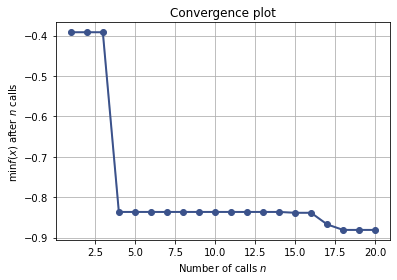

In [ ]:
from skopt.plots import plot_convergence

plot_convergence(bss.optimizer_results_)
print("Finished:", datetime.datetime.now())

In [ ]:
bss.best_params_

OrderedDict([('basemodel__batch_size', 124),
             ('basemodel__epochs', 42),
             ('basemodel__model__activation', 'tanh'),
             ('basemodel__model__dropout', 0.36325643292778165),
             ('basemodel__model__layer1', 405),
             ('basemodel__model__layer2', 313),
             ('basemodel__model__learning_rate', 0.006786656514894841),
             ('basemodel__model__optim', keras.optimizer_v2.rmsprop.RMSprop),
             ('basemodel__validation_split', 0.43731520125606826),
             ('clip_y', 93),
             ('scaler', StandardScaler()),
             ('seq_length', 30)])

# LSTM 1-layer




## Linear RUL

Score: 0.7965826139501325  
Test: 0.706
```
('basemodel__batch_size', 32),
('basemodel__epochs', 28),
('basemodel__model__activation', 'tanh'),
('basemodel__model__dropout', 0.10771222326909816),
('basemodel__model__layer1', 505),
('basemodel__model__learning_rate', 0.0032806529941975817),
('basemodel__model__optim', keras.optimizer_v2.rmsprop.RMSprop),
('basemodel__validation_split', 0.1),
('scaler', MinMaxScaler()),
('seq_length', 70)
```

## Non-Linear RUL
Score: 0.9430289602358563  
Test: 0.857
```
('basemodel__batch_size', 32),
('basemodel__epochs', 50),
('basemodel__model__activation', 'tanh'),
('basemodel__model__dropout', 0.1),
('basemodel__model__layer1', 512),
('basemodel__model__learning_rate', 0.0001),
('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
('basemodel__validation_split', 0.1),
('clip_y', 105),
('scaler', MinMaxScaler()),
('seq_length', 68)
```

## Linear RUL + Poly
Score: 0.8254078138058109  
Test: 0.
```
('basemodel__batch_size', 32),
('basemodel__epochs', 43),
('basemodel__model__activation', 'tanh'),
('basemodel__model__dropout', 0.12031183587891998),
('basemodel__model__layer1', 291),
('basemodel__model__learning_rate', 0.0005169281218693581),
('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
('basemodel__validation_split', 0.1),
('poly_degree', 3),
('scaler', StandardScaler()),
('seq_length', 61)
```

## Non-Linear RUL + Poly
Score: 0.8183215542558463  
Test: 0.
```
('basemodel__batch_size', 118),
             ('basemodel__epochs', 32),
             ('basemodel__model__activation', 'tanh'),
             ('basemodel__model__dropout', 0.3795770073881617),
             ('basemodel__model__layer1', 432),
             ('basemodel__model__learning_rate', 0.00806882152030281),
             ('basemodel__model__optim', keras.optimizer_v2.rmsprop.RMSprop),
             ('basemodel__validation_split', 0.7235243202098837),
             ('clip_y', 105),
             ('poly_degree', 3),
             ('scaler', StandardScaler()),
             ('seq_length', 79)
```




# LSTM 2-layer




## Linear RUL

Score: 0.7036942110742231  
Test: 0.
```
('basemodel__batch_size', 32),
             ('basemodel__epochs', 29),
             ('basemodel__model__activation', 'tanh'),
             ('basemodel__model__dropout', 0.23530299114462505),
             ('basemodel__model__layer1', 162),
             ('basemodel__model__layer2', 487),
             ('basemodel__model__learning_rate', 0.004875393938118097),
             ('basemodel__model__optim', keras.optimizer_v2.rmsprop.RMSprop),
             ('basemodel__validation_split', 0.19866467635377297),
             ('scaler', MinMaxScaler()),
             ('seq_length', 49)
```

## Non-Linear RUL
Score: 0.8811232847407394  
Test: 0.
```
('basemodel__batch_size', 124),
             ('basemodel__epochs', 42),
             ('basemodel__model__activation', 'tanh'),
             ('basemodel__model__dropout', 0.36325643292778165),
             ('basemodel__model__layer1', 405),
             ('basemodel__model__layer2', 313),
             ('basemodel__model__learning_rate', 0.006786656514894841),
             ('basemodel__model__optim', keras.optimizer_v2.rmsprop.RMSprop),
             ('basemodel__validation_split', 0.43731520125606826),
             ('clip_y', 93),
             ('scaler', StandardScaler()),
             ('seq_length', 30)
```

## Linear RUL + Poly
Score: 0.  
Test: 0.
```

```

## Non-Linear RUL + Poly
Score: 0.  
Test: 0.
```

```




# LSTM Tester

In [ ]:
SEQ_LENGTH=68
CLIP=105

model = LSTMWrapperRegressor(
        clip_y=CLIP, seq_length=SEQ_LENGTH, scaler=MinMaxScaler(),
        basemodel=
            KerasRegressor(model=create_model,
                           batch_size=32,
                           epochs=50,
                           model__activation='tanh',
                           model__dropout=0.1, 
                           model__layer1=512, 
                           model__learning_rate=0.0001,
                           model__optim=Adam,
                           validation_split=0.1, 
                           verbose=0, callbacks=[es, printerCallback],
                           model__metrics=[RMSE(), R2()],
                           model__loss='mse',
                           print_summary=True
                           )
    )

In [ ]:
model.fit(X_train_, y_train)

Model: "sequential_123"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_123 (Masking)       (None, 68, 22)            0         
                                                                 
 lstm_123 (LSTM)             (None, 512)               1095680   
                                                                 
 dropout_123 (Dropout)       (None, 512)               0         
                                                                 
 dense_123 (Dense)           (None, 1)                 513       
                                                                 
Total params: 1,096,193
Trainable params: 1,096,193
Non-trainable params: 0
_________________________________________________________________
E 1	: loss=3093.311, rmse=55.618, r2=-1.509; v_loss=2320.318, v_rmse=48.170, v_r2=-0.858; 
E 2	: loss=1687.357, rmse=41.077, r2=-0.368; v_loss=1733.833, v_rmse=41.639, v_r2=-

LSTMWrapperRegressor(basemodel=KerasRegressor(batch_size=32, callbacks=[<keras.callbacks.EarlyStopping object at 0x7f21b11a6410>, <keras.callbacks.LambdaCallback object at 0x7f21b1212c90>], epochs=50, model=<function create_model at 0x7f21b1128440>, model__activation='tanh', model__dropout=0.1, model__layer1=512, model__learning_rate=0.0001, model__loss='mse', model__metrics=[<keras.metrics.RootMeanSquaredError object at 0x7f211c3243d0>, <tensorflow_addons.metrics.r_square.RSquare object at 0x7f211c3245d0>], model__optim=<class 'keras.optimizer_v2.adam.Adam'>, print_summary=True, validation_split=0.1, verbose=0),
                     clip_y=105, scaler=MinMaxScaler(), seq_length=68)

In [ ]:
# Scaling and formatting test data
test_sc = scale_test(test,model)
test_wr = gen_test_wrapper(test_sc, SEQ_LENGTH, cols=model.seq_cols)

# Clipping test labels
reclipped_y = y_test.copy()
# reclipped_y["RUL"].clip(upper=CLIP, inplace=True)

# Evaluation
eval.show_result(reclipped_y, model.basemodel.predict(test_wr))
print("Finished:", datetime.datetime.now())

R2=0.857,RMSE=-15.701
Finished: 2022-10-10 12:37:52.380820


# OFF
## Non-Linear RUL



```
LSTMWrapperRegressor(
    basemodel=KerasRegressor(
        batch_size=32, 
        epochs=23, 
        model__activation='tanh',
        model__dropout=0.30649418903936865, 
        model__layer_nodes=512, 
        model__learning_rate=0.0010472789501880123,
        model__optim=<class 'keras.optimizer_v2.rmsprop.RMSprop'>,
        validation_split=0.23542211183603107,
    clip_y=99, 
    seq_length=79)
```



In [ ]:
def create_model2(optim=Adam, dropout=0.1, activation="tanh", 
                 learning_rate=1e-3, layer1=32, layer2=None, layer3=None,
                 print_summary=False, loss='mean_squared_error',
                 metrics=[tf.keras.metrics.MeanSquaredError()]):
    model = Sequential()

    # Input-masked layer
    model.add(Masking(mask_value=-99., input_shape=INPUT_SHAPE))
    
    if (layer2 is None and layer3 is None):
        # Single LSTM layer
        model.add(LSTM(layer1, activation=activation))
        model.add(Dropout(dropout))
    elif (layer2 is not None and layer3 is None):
        # 2 stacked LSTM layers
        model.add(LSTM(layer1, activation=activation))
        model.add(Dropout(dropout))
        model.add(Dense(layer2, activation=activation))
        model.add(Dropout(dropout))
    elif (layer2 is not None and layer3 is not None):
        # 3 stacked LSTM layers
        model.add(LSTM(layer1, return_sequences=True, activation=activation))
        model.add(Dropout(dropout))
        model.add(Dense(layer2, activation=activation))
        model.add(Dropout(dropout))
        model.add(Dense(layer3, activation=activation))
        model.add(Dropout(dropout))

    # Output Layer
    model.add(Dense(1))

    model.compile(loss=loss, optimizer=optim(learning_rate=learning_rate), 
                  metrics=metrics)
    
    if(print_summary): model.summary()
    return model

In [ ]:
SEQ_LENGTH=79
CLIP=99

model = LSTMWrapperRegressor(
        clip_y=CLIP, seq_length=SEQ_LENGTH, poly_degree=2,
        basemodel=
            KerasRegressor(model=create_model2,
                           batch_size=32,
                           epochs=23,
                           validation_split=0.23542211183603107, 
                           model__activation='tanh',
                           model__dropout=0.30649418903936865, 
                           model__layer1=512, 
                           model__layer2=400,
                           model__learning_rate=0.0010472789501880123,
                           model__optim=RMSprop,
                           verbose=0, callbacks=[es, printerCallback],
                           model__metrics=[RMSE(), R2()],
                           model__loss='mse',
                           print_summary=True
                           )
    )

In [ ]:
model.fit(X_train_, y_train)

Model: "sequential_259"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_259 (Masking)       (None, 79, 253)           0         
                                                                 
 lstm_397 (LSTM)             (None, 512)               1568768   
                                                                 
 dropout_398 (Dropout)       (None, 512)               0         
                                                                 
 dense_260 (Dense)           (None, 400)               205200    
                                                                 
 dropout_399 (Dropout)       (None, 400)               0         
                                                                 
 dense_261 (Dense)           (None, 1)                 401       
                                                                 
Total params: 1,774,369
Trainable params: 1,774,369


LSTMWrapperRegressor(basemodel=KerasRegressor(batch_size=32, callbacks=[<keras.callbacks.EarlyStopping object at 0x0000027F52FFEE50>, <keras.callbacks.LambdaCallback object at 0x0000027F53033D00>], epochs=23, model=<function create_model2 at 0x0000028102FA18B0>, model__activation='tanh', model__dropout=0.30649418903936865, model__layer1=512, model__layer2=400, model...010472789501880123, model__loss='mse', model__metrics=[<keras.metrics.RootMeanSquaredError object at 0x00000280AE770FD0>, <tensorflow_addons.metrics.r_square.RSquare object at 0x00000280ED328B20>], model__optim=<class 'keras.optimizer_v2.rmsprop.RMSprop'>, print_summary=True, validation_split=0.23542211183603107, verbose=0),
                     clip_y=99, poly_degree=2, seq_length=79)

In [ ]:
# Scaling and formatting test data
test_sc = scale_test(test,model)
test_wr = gen_test_wrapper(test_sc, SEQ_LENGTH, cols=model.seq_cols)

# Clipping test labels
reclipped_y = y_test.copy()
reclipped_y["RUL"].clip(upper=CLIP, inplace=True)

# Evaluation
eval.show_result(reclipped_y, model.basemodel.predict(test_wr))
print("Finished:", datetime.datetime.now())

R2=0.918,RMSE=-9.668
Finished: 2022-10-13 13:15:58.111062
